# 图像分类

在此项目中，将对 [Kaggle Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 中的图片进行分类。该数据集包含猫狗。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。


## 获取数据

下载 [Kaggle Dog Vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)。


In [1]:
"""
需要手动下载zip压缩包
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import zipfile


dog_vs_cat_dataset_folder_path = 'train'

zip_path = 'train.zip'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(zip_path):
    print('this not files in there')

if not isdir(dog_vs_cat_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall()
        zf.close()




## 探索数据

该数据集分成了两个部分：

train 数据集和 test 数据集。

训练过程中主要使用 train 数据集进行训练，然后通过test数据集进行测试。

从kaggle的题目中我们得知文件名中包含有dog 的为包含有狗的照片，包含有cat 的为包含有猫的照片。

运行下一个cell 得到的结果显示：
```
In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;

In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;

```
在测试数据集中图片是全部未标记的。需要我们训练模型之后进行结果输出。


## 获取文件夹下图片

传入floder 目录地址以读取文件，使用ratio 控制拆分数据为测试集和验证机的比率

### 随机化数据





In [3]:
import os
import numpy as np
import math
import tensorflow as tf

def get_all_files_name(floder,ratio=1):
    file_list = os.listdir(floder)
    file_list = list(map(lambda x : os.path.join(floder,x), file_list))

    dog_jpg = list(filter(lambda x : 'dog' in x  , file_list))
    cat_jpg = list(filter(lambda x : 'cat' in x  , file_list))

    print('In the %s floder , All Jpg file is %s ;' % (floder, len(file_list)))
    print('In the %s floder , Dog jpg file is %s ;' % (floder, len(dog_jpg)))
    print('In the %s floder , Cat Jpg file is %s ;' % (floder, len(cat_jpg)))
    
    
    image_list = np.hstack((cat_jpg, dog_jpg))
    label_list = np.hstack(([0] * len(cat_jpg), [1]*len(dog_jpg)))
    
    # 将数据打乱为随机数据
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp) 
    
    all_image_list = temp[:, 0]
    all_label_list = temp[:, 1]
    
    #计算数据划分的训练集和验证集的分割点
    n_sample = len(all_label_list)
    n_val = math.ceil(n_sample*ratio) # number of validation samples
    n_train = n_sample - n_val # number of trainning samples
    
    #依据分割点划分数据
    tra_images = all_image_list[0:n_train]
    tra_labels = all_label_list[0:n_train]
    tra_labels = [int(float(i)) for i in tra_labels]
    val_images = all_image_list[n_train:-1]
    val_labels = all_label_list[n_train:-1]
    val_labels = [int(float(i)) for i in val_labels]
    
    return tra_images,tra_labels,val_images,val_labels
    
    
get_all_files_name('test')

tra_images,tra_labels,val_images,val_labels = get_all_files_name('train')

In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;
In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;


## 实现预处理函数

### 标准化

对输入的图片进行标准化，然后返回 图片batch


In [2]:
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    '''
    Args:
        image: list type
        label: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''
    # 如果想看到正常的图片，请注释掉（标准化）和 130行（image_batch = tf.cast(image_batch, tf.float32)）
    # 训练时，不要注释掉！
    
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)

    # make an input queue
    input_queue = tf.train.slice_input_producer([image, label])
    
    label = input_queue[1]
    image_contents = tf.read_file( input_queue[0])
    
    
    ## 图片标准化 注释这一行和下面cast可以看到正常图片
    image = tf.image.decode_jpeg(image_contents, channels=3)
    
    # 裁剪图片
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)    
    image = tf.image.per_image_standardization(image)
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size= batch_size,
                                                num_threads= 64, 
                                                capacity = capacity)
    label_batch = tf.reshape(label_batch, [batch_size])
    
    ## 图片向量转化
    image_batch = tf.cast(image_batch, tf.float32)
    
    return image_batch, label_batch

# 测试图片标准化函数

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 2
CAPACITY = 256
IMG_W = 208
IMG_H = 208

train_dir = 'train/'
ratio = 0.2
tra_images, tra_labels, val_images, val_labels = get_all_files_name(train_dir, ratio)
tra_image_batch, tra_label_batch = get_batch(tra_images, tra_labels, IMG_W, IMG_H, BATCH_SIZE, CAPACITY)

In the train/ floder , All Jpg file is 25000 ;
In the train/ floder , Dog jpg file is 12500 ;
In the train/ floder , Cat Jpg file is 12500 ;


label: 1


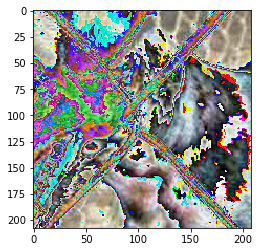

label: 0


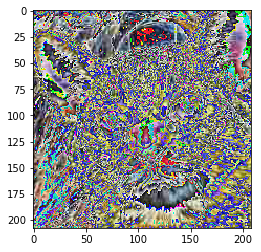

In [5]:
with tf.Session() as sess:
   i = 0
   coord = tf.train.Coordinator()
   threads = tf.train.start_queue_runners(coord=coord)
   
   try:
       while not coord.should_stop() and i<1:
           
           img, label = sess.run([tra_image_batch, tra_label_batch])
           
           # just test one batch
           for j in np.arange(BATCH_SIZE):
               print('label: %d' %label[j])
               plt.imshow(img[j,:,:,:])
               plt.show()
           i+=1
           
   except tf.errors.OutOfRangeError:
       print('done!')
   finally:
       coord.request_stop()
   coord.join(threads)

## 构建网络

对于该神经网络，你需要将每层都构建为一个函数。你看到的大部分代码都位于函数外面。要更全面地测试你的代码，我们需要你将每层放入一个函数中。这样使我们能够提供更好的反馈，并使用我们的统一测试检测简单的错误，然后再提交项目。

>**注意**：如果你觉得每周很难抽出足够的时间学习这门课程，我们为此项目提供了一个小捷径。对于接下来的几个问题，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 程序包中的类来构建每个层级，但是“卷积和最大池化层级”部分的层级除外。TF Layers 和 Keras 及 TFLearn 层级类似，因此很容易学会。

>但是，如果你想充分利用这门课程，请尝试自己解决所有问题，不使用 TF Layers 程序包中的任何类。你依然可以使用其他程序包中的类，这些类和你在 TF Layers 中的类名称是一样的！例如，你可以使用 TF Neural Network 版本的 `conv2d` 类 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)，而不是 TF Layers 版本的 `conv2d` 类 [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)。

我们开始吧！



In [5]:
def create_var(var_name, shape, dtype,init):
    return tf.get_variable(var_name, shape=shape, dtype=dtype,initializer=init)

def create_wb( weight_shape, biase_shape,stddev):
    weights = create_var('weights',
                         shape=weight_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal_initializer(stddev=stddev,dtype=tf.float32))
    biases = create_var('biases',
                         shape=biase_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal(0.1),
                       reuse=tf.AUTO_REUSE)
    return weights, biases


def get_pre_activation(images,weight_shape, biases_shape,stddev,strides):
    weights , biases = create_wb(weight_shape, biases_shape,stddev=stddev )
    conv = tf.nn.conv2d(images, weights, strides = strides,pandding='SAME')
    pre_activation = tf.nn.bias_add(conv,biases)
    return pre_activation
    


In [6]:
def inference(images, batch_size, n_classes):
    '''Build the model
    Args:
        images: image batch, 4D tensor, tf.float32, [batch_size, width, height, channels]
    Returns:
        output tensor with the computed logits, float, [batch_size, n_classes]
    '''
    #conv1, shape = [kernel size, kernel size, channels, kernel numbers]
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights', 
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name= scope.name)
    
    #pool1 and norm1   
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm1')
    
    #conv2
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weights',
                                  shape=[3,3,16,16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[16], 
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1,1,1,1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
    
    
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')
    
    
    #local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable('weights',
                                  shape=[dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)    
    
    #local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
     
        
    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('softmax_linear',
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[n_classes],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
    
    return softmax_linear

In [7]:
def losses(logits, labels):
    '''Compute loss from logits and labels
    Args:
        logits: logits tensor, float, [batch_size, n_classes]
        labels: label tensor, tf.int32, [batch_size]
        
    Returns:
        loss tensor of float type
    '''
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits\
                        (logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss

In [8]:
def evaluation(logits, labels):
  """Evaluate the quality of the logits at predicting the label.
  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).
  Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
  """
  with tf.variable_scope('accuracy') as scope:
      correct = tf.nn.in_top_k(logits, labels, 1)
      correct = tf.cast(correct, tf.float16)
      accuracy = tf.reduce_mean(correct)
      tf.summary.scalar(scope.name+'/accuracy', accuracy)
  return accuracy

In [9]:

def trainning(loss, learning_rate):
    '''Training ops, the Op returned by this function is what must be passed to 
        'sess.run()' call to cause the model to train.
        
    Args:
        loss: loss tensor, from losses()
        
    Returns:
        train_op: The op for trainning
    '''
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op



In [10]:
import os
import numpy as np
import tensorflow as tf


#%%

N_CLASSES = 2
IMG_W = 208  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2 # take 20% of dataset as validation data 
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 6000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001


#%%
def run_training():
    
    # you need to change the directories to yours.
    train_dir = 'train/'
    logs_train_dir = 'logs/train/'
    logs_val_dir = 'logs/val/'
    
    train, train_label, val, val_label = get_all_files_name(train_dir, RATIO)
    train_batch, train_label_batch = get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE, 
                                                  CAPACITY)
    train_logits = inference(train_batch, BATCH_SIZE, N_CLASSES)
    train_loss = losses(train_logits, train_label_batch)        
    train_op = trainning(train_loss, learning_rate)
    train__acc = evaluation(train_logits, train_label_batch)
       
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                    break
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])
               
            if step % 50 == 0:
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, step)
            
            if step % 2000 == 0 or (step + 1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)
                
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()
        
    coord.join(threads)
    sess.close()

In [ ]:
run_training()

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def get_test_image():
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    test_dir = 'test'
    file_list = os.listdir(test_dir)
    file_list = list(map(lambda x: os.path.join(test_dir, x), file_list))
    images = []
    for img_dir in file_list:
        image = Image.open(img_dir)
        #         plt.imshow(image)
        image = image.resize([208, 208])
        image = np.array(image)
        images.append((img_dir, image))
    return images

def evaluate_one_image(image_array):
    '''Test one image against the saved models and parameters
    '''

    # you need to change the directories to yours.

    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(image_array, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 208, 208, 3])
        logit = inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        # you need to change the directories to yours.
        logs_train_dir = 'logs/train/'

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: image_array})
            max_index = np.argmax(prediction)
            pred = ''
            if max_index == 0:
                print('This is a cat with possibility %.6f' % prediction[:, 0])
                pred = prediction[:, 0]
            else:
                print('This is a dog with possibility %.6f' % prediction[:, 1])
                pred = prediction[:, 1]
            return pred


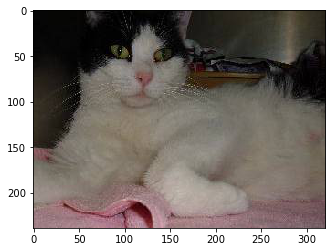

In [8]:
all_images = get_test_image()

In [ ]:
with open('result.txt', 'a+') as f:
    for img_dir, images in all_images:
        pred = evaluate_one_image(images)
        f.write(img_dir, str(pred))
